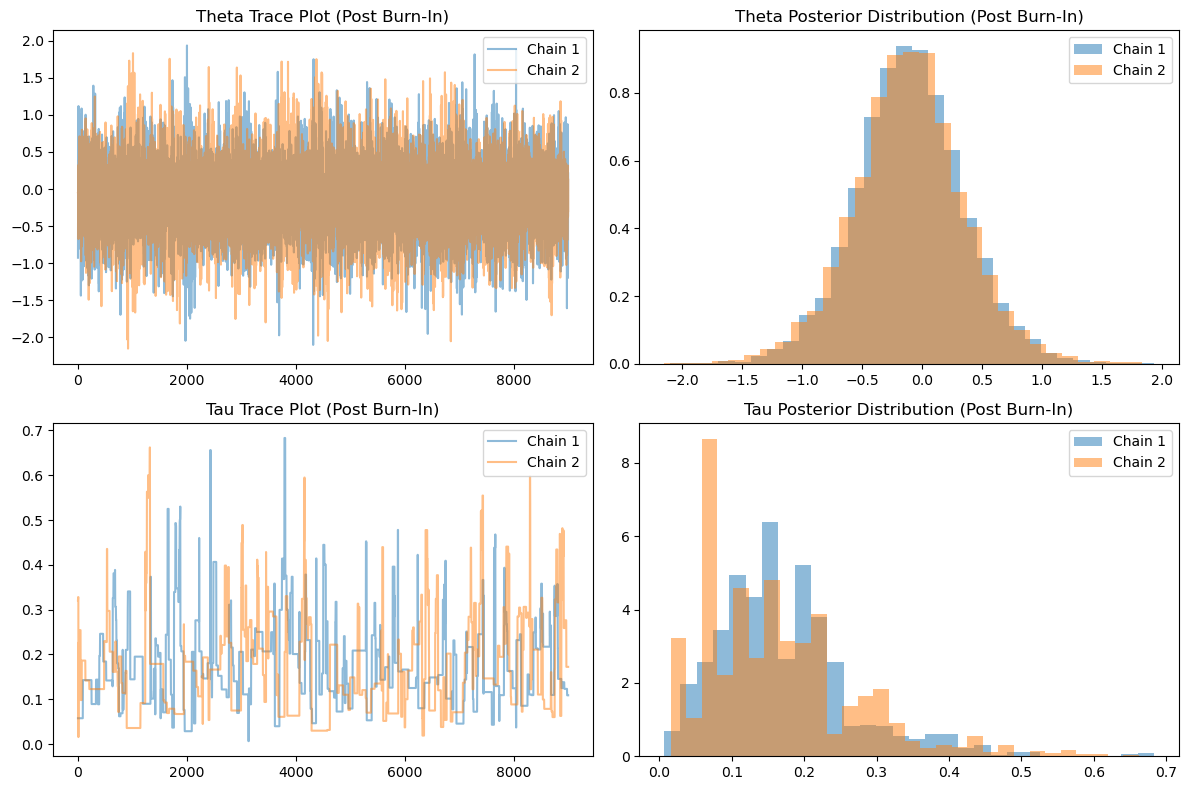

In [3]:
#Q1

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Set parameters
n = 30  # Sample size
m = 0   # True mean
s = 1   # True standard deviation
x = stats.norm(loc=m, scale=s).rvs(size=n)  # Simulated data

# Prior hyperparameters
theta0 = 0    # Prior mean for theta
tau0_sq = 1   # Prior variance for theta
alpha = 2     # Shape parameter for tau
lambda_ = 1   # Rate parameter for tau

# Metropolis within Gibbs parameters
C, G = 2, 10000  # Chains, Gibbs samples
burn = 1000  # Number of burn-in samples to discard
theta, tau = np.zeros((C, G)), np.zeros((C, G))
theta[:, 0] = 1000  # Initialize theta
tau[:, 0] = 1       # Initialize tau

# Independent proposal distribution for tau
proposal_shape, proposal_rate = alpha, lambda_  # Gamma proposal

# Joint density function (up to proportionality)
def log_joint_density(theta, tau):
    log_prior_theta = -0.5 * (theta - theta0) ** 2 / tau0_sq  # Normal prior
    log_prior_tau = (alpha - 1) * np.log(tau) - lambda_ * tau  # Gamma prior
    log_likelihood = -0.5 * tau * np.sum((x - theta) ** 2)  # Gaussian likelihood
    return log_prior_theta + log_prior_tau + log_likelihood

# Metropolis within Gibbs sampling
for c in range(C):
    for g in range(1, G):
        # Gibbs update for theta
        mean_theta = (tau[c, g-1] * np.sum(x) + theta0 / tau0_sq) / (tau[c, g-1] * n + 1 / tau0_sq)
        var_theta = 1 / (tau[c, g-1] * n + 1 / tau0_sq)
        theta[c, g] = stats.norm.rvs(loc=mean_theta, scale=np.sqrt(var_theta))
        
        # Metropolis-Hastings update for tau
        tau_proposed = stats.gamma.rvs(a=proposal_shape, scale=1/proposal_rate)
        log_acceptance_ratio = log_joint_density(theta[c, g], tau_proposed) - 
        log_joint_density(theta[c, g], tau[c, g-1])
        
        if np.log(stats.uniform.rvs()) < log_acceptance_ratio:
            tau[c, g] = tau_proposed  # Accept proposal
        else:
            tau[c, g] = tau[c, g-1]  # Reject proposal and keep previous tau

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for c in range(C):
    axes[0, 0].plot(theta[c, burn:], alpha=0.5, label=f'Chain {c+1}')
    axes[1, 0].plot(tau[c, burn:], alpha=0.5, label=f'Chain {c+1}')
    axes[0, 1].hist(theta[c, burn:], bins=30, density=True, alpha=0.5, label=f'Chain {c+1}')
    axes[1, 1].hist(tau[c, burn:], bins=30, density=True, alpha=0.5, label=f'Chain {c+1}')

axes[0, 0].set_title("Theta Trace Plot (Post Burn-In)")
axes[1, 0].set_title("Tau Trace Plot (Post Burn-In)")
axes[0, 1].set_title("Theta Posterior Distribution (Post Burn-In)")
axes[1, 1].set_title("Tau Posterior Distribution (Post Burn-In)")
for ax in axes.flatten(): ax.legend()
plt.tight_layout()
plt.show()


Since my Q2's Gibbs sampler in last HW implementation was not successful, so I learned the Gibbs Sampler from Sample1 prof provided on Piazza.

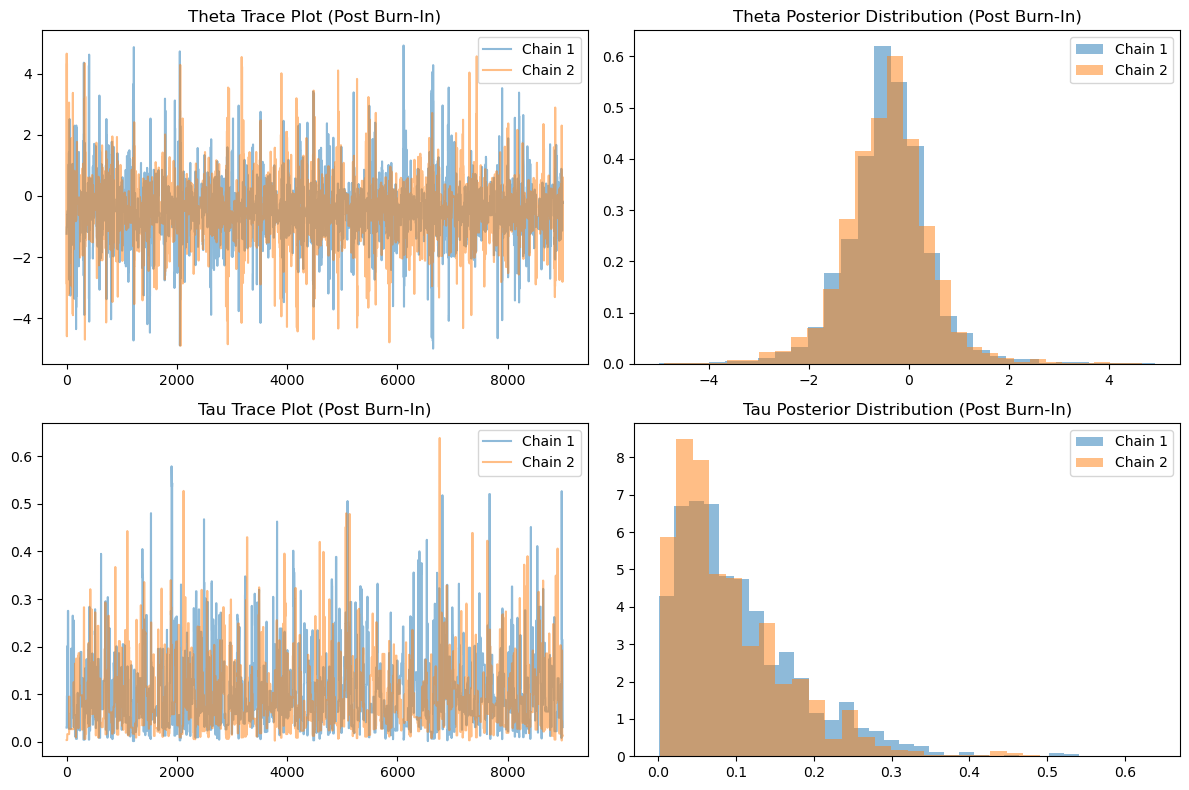

In [5]:
#Q2

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Set parameters
n = 30  # Sample size
m = 0   # True mean
s = 1   # True standard deviation
x = stats.norm(loc=m, scale=s).rvs(size=n)  # Simulated data

# Prior hyperparameters
theta_min, theta_max = -5, 5  # Uniform prior bounds for theta
tau0_sq = 1   # Prior variance for tau
alpha = 2     # Shape parameter for tau
lambda_ = 1   # Rate parameter for tau

# Metropolis within Gibbs parameters
C, G = 2, 10000  # Chains, Gibbs samples
burn = 1000  # Number of burn-in samples to discard
theta, tau = np.zeros((C, G)), np.zeros((C, G))
theta[:, 0] = 1000  # Initialize theta
tau[:, 0] = 1       # Initialize tau

# Joint density function (up to proportionality)
def log_joint_density(theta, tau):
    log_prior_theta = np.log(1 / (theta_max - theta_min)) if theta_min <= theta <= theta_max else -np.inf
    log_prior_tau = (alpha - 1) * np.log(tau) - lambda_ * tau  # Gamma prior
    log_likelihood = -0.5 * tau * np.sum((x - theta) ** 2)  # Gaussian likelihood
    return log_prior_theta + log_prior_tau + log_likelihood

# Metropolis within Gibbs sampling
for c in range(C):
    for g in range(1, G):
        # Gibbs update for theta
        theta_proposed = stats.uniform.rvs(loc=theta_min, scale=(theta_max - theta_min))
        log_acceptance_ratio_theta = log_joint_density(theta_proposed, tau[c, g-1]) - log_joint_density(theta[c, g-1], tau[c, g-1])
        
        if np.log(stats.uniform.rvs()) < log_acceptance_ratio_theta:
            theta[c, g] = theta_proposed  # Accept proposal
        else:
            theta[c, g] = theta[c, g-1]  # Reject proposal and keep previous theta

        # Metropolis-Hastings update for tau
        tau_t_minus_1 = tau[c, g-1]
        tau_proposed = stats.truncnorm.rvs(a=(-tau_t_minus_1 / s), b=np.inf, loc=tau_t_minus_1, scale=s)
        log_acceptance_ratio_tau = log_joint_density(theta[c, g], tau_proposed) - log_joint_density(theta[c, g], tau_t_minus_1)
        
        if np.log(stats.uniform.rvs()) < log_acceptance_ratio_tau:
            tau[c, g] = tau_proposed  # Accept proposal
        else:
            tau[c, g] = tau[c, g-1]  # Reject proposal and keep previous tau

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for c in range(C):
    axes[0, 0].plot(theta[c, burn:], alpha=0.5, label=f'Chain {c+1}')
    axes[1, 0].plot(tau[c, burn:], alpha=0.5, label=f'Chain {c+1}')
    axes[0, 1].hist(theta[c, burn:], bins=30, density=True, alpha=0.5, label=f'Chain {c+1}')
    axes[1, 1].hist(tau[c, burn:], bins=30, density=True, alpha=0.5, label=f'Chain {c+1}')

axes[0, 0].set_title("Theta Trace Plot (Post Burn-In)")
axes[1, 0].set_title("Tau Trace Plot (Post Burn-In)")
axes[0, 1].set_title("Theta Posterior Distribution (Post Burn-In)")
axes[1, 1].set_title("Tau Posterior Distribution (Post Burn-In)")
for ax in axes.flatten(): ax.legend()
plt.tight_layout()
plt.show()


Q2, continued

In Gibbs sampling, deriving the full conditional distributions is essential but can be analytically challenging or infeasible for complex models. When available, these full conditionals make Gibbs sampling computationally efficient with high acceptance rates. However, when they are intractable, the Metropolis-Hastings within Gibbs approach provides a practical alternative by enabling sampling from the joint posterior using proposal distributions. This method offers greater flexibility, allowing the use of tailored proposal distributions to improve efficiency and priors that complicate direct conditional derivation, making it a versatile tool for Bayesian inference in complex scenarios.

Necessity in Gibbs Sampling:
Gibbs sampling typically requires closed-form full conditional distributions for direct sampling.
When these are unavailable, Metropolis-Hastings steps can be introduced within the Gibbs framework to approximate the conditional distributions.

Advantages of Metropolis-Hastings in Gibbs:
Flexibility to handle cases where full conditionals are intractable.
Retains the iterative structure of Gibbs sampling while allowing for more complex priors or likelihoods.

Trade-Offs:
Metropolis-Hastings can be less efficient due to the possibility of rejecting proposals.
Requires careful tuning of proposal distributions to ensure good mixing and convergence.

##Q3

The proposal distribution is defined as:
$$
q\left(\tilde{x}^{(t)} \mid x^{(t-1)}\right) = \left(\frac{1}{2}\right)^{1-\tilde{x}^{(t)}} \left(\frac{1}{2}\right)^{\tilde{x}^{(t)}},
$$
which is symmetric, meaning:
$$
q(0 \mid 1) = q(1 \mid 0) = \frac{1}{2}, \quad q(0 \mid 0) = q(1 \mid 1) = \frac{1}{2}.
$$


The stationary distribution is given as:
$$
p\left(x^{(t)}\right) = \left(\frac{1}{3}\right)^{1-x^{(t)}} \left(\frac{2}{3}\right)^{x^{(t)}},
$$
implying:
$$
p(0) = \frac{1}{3}, \quad p(1) = \frac{2}{3}.
$$

The acceptance probability in the Metropolis-Hastings algorithm is:
$$
\alpha\left(x^{(t-1)} \rightarrow \tilde{x}^{(t)}\right) = \min \left(1, \frac{p\left(\tilde{x}^{(t)}\right)}{p\left(x^{(t-1)}\right)} \frac{q\left(x^{(t-1)} \mid \tilde{x}^{(t)}\right)}{q\left(\tilde{x}^{(t)} \mid x^{(t-1)}\right)}\right).
$$

Since the proposal distribution is symmetric, the ratio of proposals cancels out:
$$
\frac{q\left(x^{(t-1)} \mid \tilde{x}^{(t)}\right)}{q\left(\tilde{x}^{(t)} \mid x^{(t-1)}\right)} = 1.
$$

Thus, the acceptance probability simplifies to:
$$
\alpha\left(x^{(t-1)} \rightarrow \tilde{x}^{(t)}\right) = \min \left(1, \frac{p\left(\tilde{x}^{(t)}\right)}{p\left(x^{(t-1)}\right)}\right).
$$

Substituting \( p(0) = \frac{1}{3} \) and \( p(1) = \frac{2}{3} \), we compute:
$$
\begin{aligned}
\alpha(1 \to 0) &= \min \left(1, \frac{p(0)}{p(1)}\right) = \min \left(1, \frac{\frac{1}{3}}{\frac{2}{3}}\right) = \frac{1}{2}, \\
\alpha(0 \to 1) &= \min \left(1, \frac{p(1)}{p(0)}\right) = \min \left(1, \frac{\frac{2}{3}}{\frac{1}{3}}\right) = 1.
\end{aligned}
$$

Now, we compute the elements of the transition kernel \( K \):

1. **Probability of Staying at 0**:
$$
\begin{aligned}
K(0 \to 0) &= q(1 \mid 0) \cdot (1 - \alpha(0 \to 1)) + q(0 \mid 0) \\
&= \frac{1}{2} \cdot (1 - 1) + \frac{1}{2} \\
&= 0.5.
\end{aligned}
$$

2. **Probability of Moving from 0 to 1**:
$$
K(0 \to 1) = q(1 \mid 0) \cdot \alpha(0 \to 1) = \frac{1}{2} \cdot 1 = 0.5.
$$

3. **Probability of Moving from 1 to 0**:
$$
K(1 \to 0) = q(0 \mid 1) \cdot \alpha(1 \to 0) = \frac{1}{2} \cdot \frac{1}{2} = 0.25.
$$

4. **Probability of Staying at 1**:
$$
\begin{aligned}
K(1 \to 1) &= q(0 \mid 1) \cdot (1 - \alpha(1 \to 0)) + q(1 \mid 1) \\
&= \frac{1}{2} \cdot \left(1 - \frac{1}{2}\right) + \frac{1}{2} \\
&= 0.75.
\end{aligned}
$$

Thus, the transition kernel is:
$$
K = \begin{bmatrix}
0.5 & 0.5 \\
0.25 & 0.75
\end{bmatrix}.
$$

The stationary distribution \( \pi = [\pi_0, \pi_1] \) satisfies \( \pi K = \pi \). Solving:
$$
\begin{aligned}
\pi_0 &= 0.5 \pi_0 + 0.25 \pi_1, \\
\pi_1 &= 0.5 \pi_0 + 0.75 \pi_1, \\
\pi_0 + \pi_1 &= 1.
\end{aligned}
$$

Solving these equations yields:
$$
\pi_0 = \frac{1}{3}, \quad \pi_1 = \frac{2}{3}.
$$

The stationary distribution 
$$
(\pi = \left[\frac{1}{3}, \frac{2}{3}\right]) 
$$
matches the target distribution \( p(x) \), confirming that the Metropolis-Hastings algorithm converges to the correct stationary distribution.

